In [ ]:
from keras.models import load_model
model = load_model('/home/sergey/maga_diploma/different_models/class_text_image2.h5')

## OCR (text recognising)

In [1]:
import easyocr
import os, random
import matplotlib.pyplot as plt
from keras.preprocessing import image
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [2]:
reader = easyocr.Reader(['ru'])

In [3]:
' '.join(reader.readtext('tests/test_vetka.png', detail = 0))

'Держи, это твоя ЗАРЛЛАТА З 4 Апрель Но это вЕТКА!'

In [ ]:
all_path_images = ! for f in ../../communities/*/images/*; do echo "$f"; done

In [ ]:
path_to_pkl = ! ls ../classif_text_img/*2.pkl

In [ ]:
path_to_pkl

In [ ]:
path_to_tsv = ! ls ../classif_text_img/*2.tsv | xargs -n1 basename

In [ ]:
tsv_file = ' '.join(path_to_tsv)

In [ ]:
tsv_file

In [ ]:
unpickled_df = pd.read_pickle(*path_to_pkl) 

In [ ]:
unpickled_df.shape

In [ ]:
unpickled_df['text_ocr_image'], unpickled_df['size_text_ocr'] = np.nan, 0

In [ ]:
def get_recognition_text(my_df, path_to_images, tsv_file):
    reader = easyocr.Reader(['ru'])
    cnt = 0
    for img_path in tqdm(path_to_images):
        cnt += 1
        owner_id = img_path.split(os.sep)[-1].split('_')[1]
        id_post = img_path.split(os.sep)[-1].split('_')[-1].split('.')[0]
#         res_df[res_df['type_post'].isnull()]
        if my_df.loc[(my_df['id_community'] == owner_id) & (my_df['id_post'] == int(id_post)), 'type_post'].isnull().any():
            continue
        try:
#             img_path = base_dir + '/' + my_image
            img = image.load_img(img_path, target_size=(224, 224))

            # Show picture
    #         plt.imshow(img)
    #         plt.show()
#             ids_images.append(my_image)
            lst_text_ocr = reader.readtext(img_path, detail = 0)
#             lst_get_text.append(" ".join(result))
            text_ocr = ' '.join(lst_text_ocr)
            my_df.loc[(my_df['id_community'] == owner_id) & (my_df['id_post'] == int(id_post)), ['text_ocr_image', 'size_text_ocr']] = [text_ocr, len(text_ocr.split())] 
        except FileNotFoundError:
            print('Entered image name does not exist.', img_path)
        if cnt % 5000 == 0:
            my_df.to_csv(tsv_file, sep='\t')
    
    my_df.to_csv(tsv_file, sep='\t')
    my_df.to_pickle("./dataset_social_with_ocr_2.pkl")
    
    return my_df 

In [ ]:
proba_df = get_recognition_text(unpickled_df, all_path_images, tsv_file)

In [ ]:
proba_df.to_pickle("./dataset_social_with_ocr_2.pkl")

In [ ]:
proba_df.tail()

In [ ]:
proba_df.loc[proba_df['text_ocr_image'].notnull()]

In [ ]:
proba_df.loc[(proba_df['size_text_ocr'] > 2) & (proba_df['type_post'] == 'image'), 'type_post'] = 'img_text'

## Speller

In [4]:
def fix_spell(text, data):
    res = text[:]
    for i in range(len(text)):
#         print('=======')
#         print(text[i])
        for elem in data[i]:
            if elem['s']:
                res[i] = res[i].replace(elem['word'], elem['s'][0])
#             print(res[i])
#         print(res[i])
    return res

In [ ]:
proba_df['spell_text_ocr_image'] = ''

In [ ]:
for index, row in tqdm(proba_df.iterrows()):
    if (row['type_post'] == 'img_text' or row['type_post'] == 'image') and row['spell_text_ocr_image'] == '':
        print(index)

In [ ]:
import requests

url = 'https://speller.yandex.net/services/spellservice.json/checkTexts'
# for i in range(6, len(recog_text), 6):
cnt = 0
for index, row in tqdm(proba_df.iterrows()):
    cnt += 1
    try:
        if (row['type_post'] == 'img_text' or row['type_post'] == 'text') and row['spell_text_ocr_image'] == '':
            text_ocr = [row['text_ocr_image'].lower()]
    #         print(text_ocr)
            params = dict(text=text_ocr)
            resp = requests.get(url=url, params=params)
            data = resp.json()
            spelling_text = fix_spell(text_ocr, data)
    #         print(spelling_text)
            proba_df.at[index,'spell_text_ocr_image'] = spelling_text[0].lower()
    #         row['spell_text_ocr_image'] = spelling_text[0]
            if cnt % 5000 == 0:
                proba_df.to_csv('dataset_with_ocr_spell_2.tsv', sep='\t')
    #     if cnt == 10:
    #         break
    except:
        proba_df.at[index,'spell_text_ocr_image'] = 'Error: uri'

proba_df.to_csv('dataset_with_ocr_spell_2.tsv', sep='\t')
proba_df.to_pickle("./dataset_social_with_ocr_spell_2.pkl")

In [ ]:
pd.isna(proba_df['spell_text_ocr_image']).values.any()

### Хороший пример того, как можно ошибку выявить

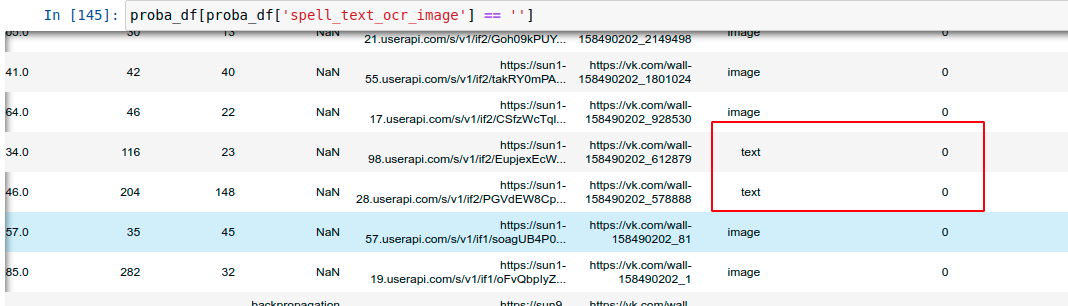

In [ ]:
proba_df[proba_df['spell_text_ocr_image'] == '']

### Здесь показано, как можно выявить неудавшийся спеллинг текста

In [ ]:
proba_df[proba_df['spell_text_ocr_image'] == 'Error: uri']

In [ ]:
proba_df = pd.read_pickle('./dataset_social_with_ocr_spell_2.pkl')

## Sentiment Analysis (Dostoevsky)

In [ ]:
proba_df.to_csv('dataset_with_ocr_spell_sent.tsv', sep='\t')
proba_df.to_pickle("./dataset_social_with_ocr_spell_sent_1.pkl")

In [ ]:
proba_df = pd.read_csv('dataset_with_ocr_spell_2.tsv', sep='\t')

In [ ]:
proba_df.head()

In [ ]:
del proba_df['Unnamed: 0']

In [ ]:
proba_df['sentiment_text_post_1'] = ''
proba_df['sentiment_text_post_2'] = ''
proba_df['level_sentiment_post_1'] = np.nan
proba_df['level_sentiment_post_2'] = np.nan
proba_df['sentiment_text_ocr_image_1'] = ''
proba_df['sentiment_text_ocr_image_2'] = ''
proba_df['level_sentiment_ocr_1'] = np.nan
proba_df['level_sentiment_ocr_2'] = np.nan

In [ ]:
proba_df.head()

In [ ]:
proba_df = proba_df.fillna(value={'text_post': '', 'spell_text_ocr_image': ''})

In [ ]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

cnt=0
for index, row in tqdm(proba_df.iterrows()):
    cnt += 1
    if (row['type_post'] == 'img_text' or row['type_post'] == 'text') and row['spell_text_ocr_image'] != '':
        text_spell_ocr = [row['spell_text_ocr_image']]
#         print(text_spell_ocr)
        sent_ocr = model.predict(text_spell_ocr, k=2)
#         print(sent_ocr)
        for message, sentiment in zip(text_spell_ocr, sent_ocr):

            level_sentiment_1 = list(sentiment.values())[0]
            proba_df.at[index,'level_sentiment_ocr_1'] = level_sentiment_1

            level_sentiment_2 = list(sentiment.values())[1]
            proba_df.at[index,'level_sentiment_ocr_2'] = level_sentiment_2
            
#                 print(message, '->', list(sentiment)[0])
            proba_df.at[index,'sentiment_text_ocr_image_1'] = list(sentiment)[0]
            proba_df.at[index,'sentiment_text_ocr_image_2'] = list(sentiment)[1]
    
    if row['text_post'] != '':
        field_text_post = [row['text_post']]
#         print(field_text_post)
        sent_post = model.predict(field_text_post, k=2)

        for message, sentiment in zip(field_text_post, sent_post):

            level_sentiment_post_1 = list(sentiment.values())[0]
            proba_df.at[index,'level_sentiment_post_1'] = level_sentiment_post_1

            level_sentiment_post_2 = list(sentiment.values())[1]
            proba_df.at[index,'level_sentiment_post_2'] = level_sentiment_post_2

            proba_df.at[index,'sentiment_text_post_1'] = list(sentiment)[0]
            proba_df.at[index,'sentiment_text_post_2'] = list(sentiment)[1]
        
    if cnt % 5000 == 0:
        proba_df.to_csv('dataset_with_ocr_spell_sent_2.tsv', sep='\t')

proba_df.to_csv('dataset_with_ocr_spell_sent_2.tsv', sep='\t')
proba_df.to_pickle("./dataset_social_with_ocr_spell_sent_2.pkl") 

In [ ]:
proba_df.loc[proba_df['sentiment_text_ocr_image_1'].notnull()]

In [ ]:
with open('lst_texts.pickle', 'rb') as handle:
    lst_texts = pickle.load(handle)

In [ ]:
with open('russian-words-master/russian.utf-8', 'r') as f:
    words = set(f.read().splitlines())

In [ ]:
import re
re.sub(r'[^А-Яа-яЁё\- ]', '', res[5])

In [ ]:
def perc_unknown_words(s, vocab):
    words = s.lower().split()
    res =  sum(1 for w in words if w not in vocab ) / len(words) if len(words) > 0 else 0

#     if res > 0.8:
# #         print(s)
#         for w in words:
#             if w not in vocab:
#                 print(w)
    return res

## Пример спеллера

In [5]:
https://speller.yandex.net/services/spellservice.json/checkTexts?text=синхрафазатрон&text=в+дубне&callback=myCallback

SyntaxError: invalid syntax (<ipython-input-5-b05780cb7e80>, line 1)

In [ ]:
text = ['это неоченб точно набранрнрое предлож эение',
    'влесу роодиллась ел о чка', 'всё хорошо']

In [16]:
new_text = ['Держи, это твя ЗАРЛЛАТА з А Апрель Но это вЕТКА!']

In [17]:
import requests

url = 'https://speller.yandex.net/services/spellservice.json/checkTexts'
params = dict(text=new_text)
resp = requests.get(url=url, params=params)
resp.json()

[[{'code': 1,
   'pos': 11,
   'row': 0,
   'col': 11,
   'len': 3,
   'word': 'твя',
   's': ['твоя']},
  {'code': 1,
   'pos': 15,
   'row': 0,
   'col': 15,
   'len': 8,
   'word': 'ЗАРЛЛАТА',
   's': ['ЗАРПЛАТА']},
  {'code': 1,
   'pos': 24,
   'row': 0,
   'col': 24,
   'len': 3,
   'word': 'з А',
   's': ['зА']}]]

## Без обработки регулярок

In [ ]:
import requests

url = 'https://speller.yandex.net/services/spellservice.json/checkTexts'
# for i in range(6, len(recog_text), 6):
data_res = []
with open('speller_recog_texts_images.pickle', 'rb') as handle:
    speller_recog_text_images = pickle.load(handle)
data_res += speller_recog_text_images
print(len(data_res))
for i in tqdm(range(22002, len(recog_text_images), 2)):
    params = dict(text=recog_text_images[i-2:i])
#     params = dict(text=recog_text_images[i])
    resp = requests.get(url=url, params=params)
    data = resp.json() # Check the JSON Response Content documentation below
    data_res += data
    if i % 1000 == 0:
        with open('speller_recog_texts_images.pickle', 'wb') as f:
            pickle.dump(data_res, f)
#         print(len(data_res))
#         break

with open('speller_recog_texts_images.pickle', 'wb') as f:
    pickle.dump(data_res, f)

## С обработкой регулярок

In [ ]:
import requests

url = 'https://speller.yandex.net/services/spellservice.json/checkTexts'
# for i in range(6, len(recog_text), 6):
cnt = 0
for index, row in tqdm(big_unpickled_df.iterrows()):
    cnt += 1
    try:
        if (row['type_post'] == 'img_text' or row['type_post'] == 'text') and row['spell_text_with_re'] == '':
            text_ocr = [re.sub(r'[^А-Яа-яЁё\- ]', '', row['text_ocr_image'].lower())]
    #         print(text_ocr)
            params = dict(text=text_ocr)
            resp = requests.get(url=url, params=params)
            data = resp.json()
            spelling_text = fix_spell(text_ocr, data)
    #         print(spelling_text)
            big_unpickled_df.at[index,'spell_text_with_re'] = spelling_text[0].lower()
    #         row['spell_text_ocr_image'] = spelling_text[0]
            if cnt % 5000 == 0:
                big_unpickled_df.to_csv('final_dataset.tsv', sep='\t')
    #     if cnt == 10:
    #         break
    except:
        big_unpickled_df.at[index,'spell_text_with_re'] = 'Error: uri'

big_unpickled_df.to_csv('final_dataset.tsv', sep='\t')
big_unpickled_df.to_pickle("./final_dataset_social.pkl")

## Обработка после OFA

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date, datetime as dt
import numpy as np
from tqdm import tqdm
import altair as alt
from vega_datasets import data
import re

In [ ]:
unpickled_df_1 = pd.read_pickle('/home/sergey/maga_diploma/models/OFA/dataset_social_with_ocr_spell_sent_ofa_1.pkl') 

In [ ]:
unpickled_df_2 = pd.read_pickle('/home/sergey/maga_diploma/models/OFA/dataset_social_with_ocr_spell_sent_ofa_2.pkl') 

In [ ]:
unpickled_df_1.head()

In [ ]:
final_df = pd.read_pickle('./final_dataset_social.pkl')

In [ ]:
final_df['dayofweek'] = final_df['date'].dt.dayofweek
final_df['weekend'] = final_df['dayofweek'] > 4
for f in 'count_likes', 'count_views', 'count_comments','count_reposts':
    final_df[f"log_{f}"] = np.log10(final_df[f]+1)

In [ ]:
final_df.to_pickle('./dataset_social_final_finish.pkl')

In [ ]:
final_df = pd.read_pickle('./dataset_social_final_finish.pkl')

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=final_df['date'].values, y=final_df['log_count_likes'].values, alpha=0.1)

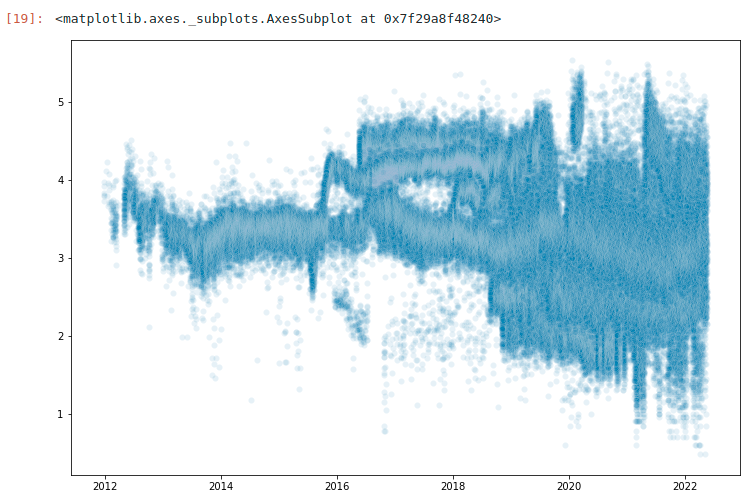

In [ ]:
final_df['year'].groupby([final_df.type_post, final_df.year]).agg('count')

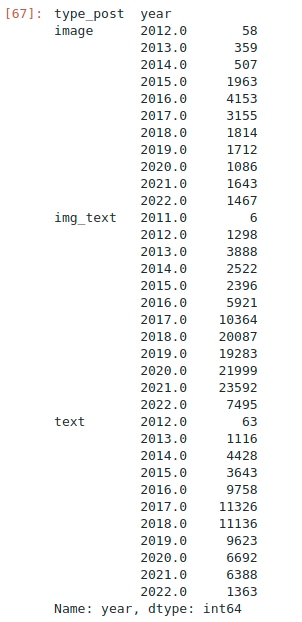

## Примеры с altair

In [ ]:
alt.Chart(final_df[:150000]).mark_area().encode(
    x=alt.X('date:T',
        timeUnit='yearmonth',
        axis=alt.Axis(format='%Y', labelAngle=0, title='year')
    ),
    y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%')),
    color="type_post:N",
    facet=alt.Facet('id_community:O', columns=4)
).properties(width=250, height=200)

In [ ]:
alt.Chart(unpickled_df).mark_area().encode(
    x=alt.X('date:T',
        timeUnit='yearmonth',
        axis=alt.Axis(format='%Y', labelAngle=0, title='year')
    ),
    y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%')),
    color="type_post:N"
)

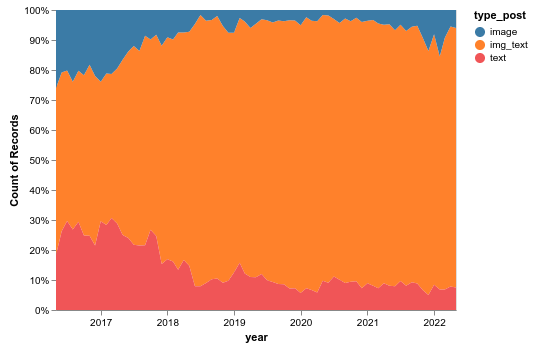

In [ ]:
x = np.linspace(0, 10)
y = np.sin(x) + 0.1 * np.random.randn(len(x))

df = pd.DataFrame({
    'x': x,
    'y2' : y + 0.6,
    'y': y,
    'upper': y + 0.5 * (1 + np.random.rand(len(x))),
    'lower': y - 0.5 * (1 + np.random.rand(len(x)))
})

line = alt.Chart(df).mark_line(
    color='firebrick'
).encode(
    x='x',
    y='y'
)

line2 = alt.Chart(df).mark_line(
    color='forestgreen'
).encode(
    x='x',
    y='y2'
)

band = alt.Chart(df).mark_area(
    opacity=0.5, color='gray'
).encode(
    x='x',
    y='lower',
    y2='upper'
)

band + line + line2

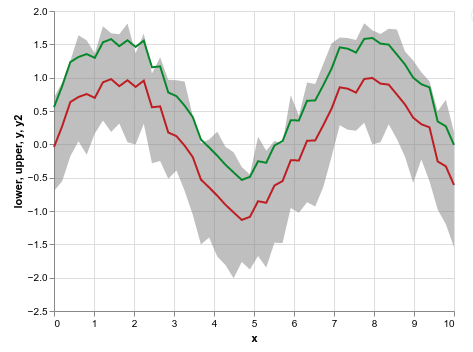

In [ ]:
alt.Chart(unpickled_df).mark_area().encode(
    x="yearmonth(date)",
    y=alt.Y("count()", stack="normalize"),
    color="type_post:N",
    facet=alt.Facet('id_community:O', columns=4)
).properties(width=200, height=150)

## Анализ графиков

In [ ]:
df = pd.read_csv('dataset_with_ocr_spell_sent_ofa.tsv', sep='\t')

In [ ]:
df.shape

In [ ]:
del df['Unnamed: 0']

In [ ]:
df.head()

In [ ]:
df['id_community'].value_counts()

In [ ]:
dfm = df.query('id_community == -57846937')

In [ ]:
dfm.dtypes

In [ ]:
communities = df['id_community'].unique()
f, ax = plt.subplots(1, len(communities), figsize=(15, 8))
for i, c in enumerate(communities):
    df.query('id_community == @c')['type_post'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

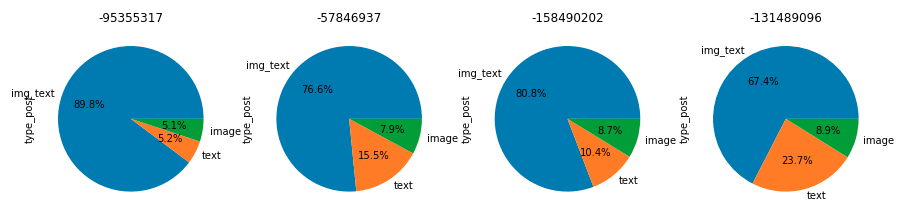

In [ ]:
communities = df['id_community'].unique()
f, ax = plt.subplots(1, len(communities), figsize=(15, 8))
for i, c in enumerate(communities):
    df.query('id_community == @c')['sentiment_text_ocr_image_1'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

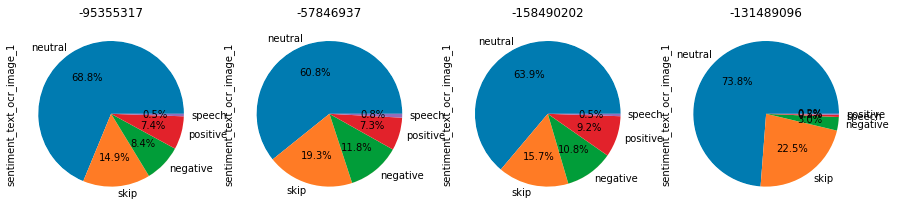

In [ ]:
communities = df['id_community'].unique()
f, ax = plt.subplots(1, len(communities), figsize=(15, 8))
for i, c in enumerate(communities):
    df.query('id_community == @c & sentiment_text_ocr_image_1 in ["skip", "neutral"]')['sentiment_text_ocr_image_2'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

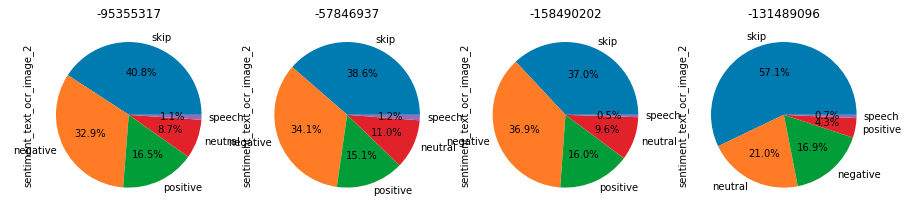

In [ ]:
g = sns.FacetGrid(df, col="id_community")#,  row="sex")
g.map(sns.distplot, 'size_text_ocr')

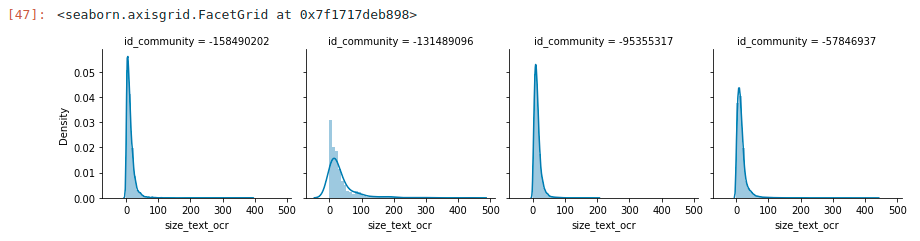

In [ ]:
dfm.count_likes.quantile(0.75)

In [ ]:
dfm.insert(len(dfm.columns), 'pop_class', 'medium')

In [ ]:
dfm.dtypes

In [ ]:
dfm.loc[dfm['count_likes'].astype(int) > 21654, 'pop_class'] = 'high'
dfm.loc[dfm['count_likes'].astype(int) < 4896, 'pop_class'] = 'low'

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15, 8))
for i, c in enumerate(['low', 'medium', 'high']):
    dfm.query('pop_class == @c')['sentiment_text_ocr_image_1'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

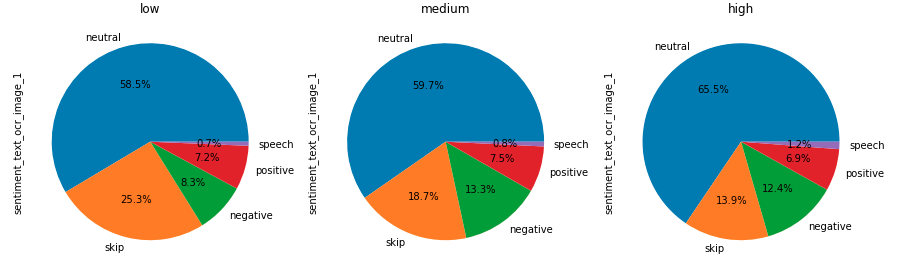

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(15, 8))
for i, c in enumerate(['low', 'medium', 'high']):
    dfm.query('pop_class == @c')['type_post'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

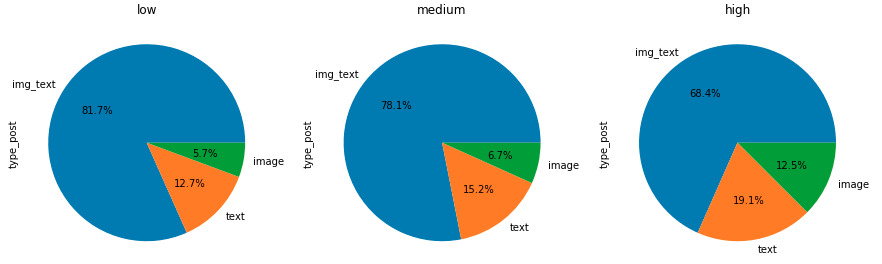

In [ ]:
g = sns.FacetGrid(dfm, col="pop_class")#,  row="sex")
g.map(sns.distplot, 'size_text_ocr')

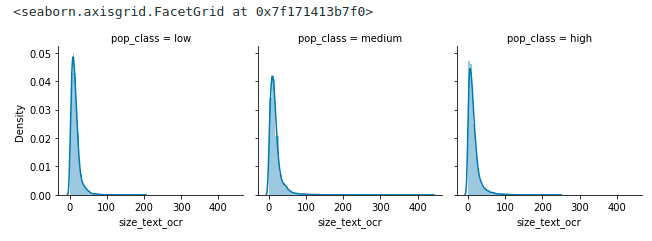